In [1]:
import xarray as xr
import numpy as np
import random
import intake

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sn

from datetime import datetime

import geopy.distance
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader

In [2]:
def calculate_edges(field, threshold, lon_band):

    latitude_values = field.latitude.values
    mean_field = field.sel(longitude=slice(*lon_bands[lon_band])).mean(dim='longitude')
    
    if (np.sum((mean_field>threshold).values) > 2) & (np.sum((mean_field>threshold).values)<len(mean_field)): 
    
        southernmost_latitude = mean_field.latitude.where(mean_field > threshold).min(dim='latitude', skipna=True).compute().values
        field_north_of_south_edge = mean_field.sel(latitude = slice(mean_field.latitude.max(), southernmost_latitude))
        northernmost_latitude = field_north_of_south_edge.latitude.where(field_north_of_south_edge < threshold).min(dim='latitude', skipna=True).compute().values

        #print("Northernmost latitude where the mean exceeds cwv_1:", northernmost_latitude.values)
        #print("Southernmost_latitude latitude where the mean exceeds cwv_1:", southernmost_latitude.values)

    else:
        print("No latitude where the mean exceeds cwv_1 found.")
        southernmost_latitude, northernmost_latitude = np.nan, np.nan

    return southernmost_latitude, northernmost_latitude

In [3]:
cat = intake.open_catalog('https://tcodata.mpimet.mpg.de/internal.yaml')
ds = cat.ORCESTRA.orcestra_preparations_era5.to_dask()

In [4]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'salNorth': 16.74, 'salEast': -22.94, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
              } 

levels_cwv = [45, 50, 55]

lon_bands = {'entire': [-50, -20], 'west': [-49, -47], 'east': [-24, -22]}

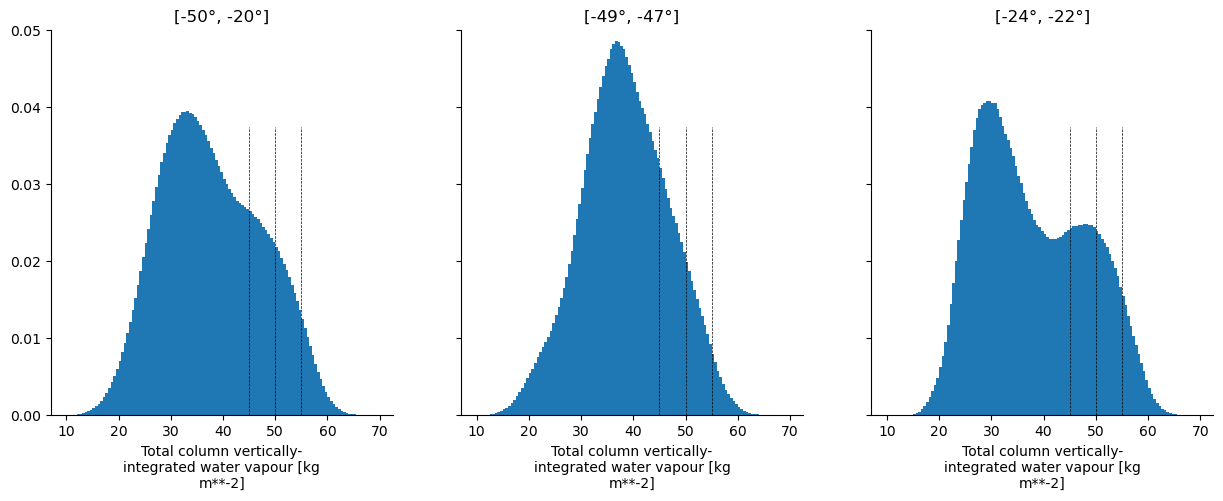

In [5]:
fig, ax = plt.subplots(1, len(lon_bands), figsize = (len(lon_bands)*5, 5), sharey = True)

for i_band, lon_band in enumerate(lon_bands):
    
    plt.sca(ax[i_band])
    lon_min, lon_max = lon_bands[lon_band]
    ds.tcwv.sel(longitude = slice (lon_min, lon_max)).plot.hist(bins = np.arange(10, 70, 0.5), density = True)
    
    for level_cwv in levels_cwv:
        plt.axvline(level_cwv, 0, 0.75, linestyle = 'dashed', color = 'k', linewidth = 0.5)
    
    plt.title(f'[{lon_min}°, {lon_max}°]')

plt.ylim(0, 0.05)

sn.despine();

In [6]:
# Flight track

circle_rad_deg = 1.0 # in deg.
halo_speed_km_h = 850

def calc_flight_track(field, lon_band):
    lon_edge1 = np.mean(lon_bands[lon_band])
    lat_edge1_south, lat_edge1_north = calculate_edges(field, 45.0, lon_band)
    
    if (np.isnan(lat_edge1_south) or np.isnan(lat_edge1_north)):
        return None
    
    else:
        # Circles
        circle_coords = [(lon_edge1, lat_edge1_north), (lon_edge1, (lat_edge1_north+lat_edge1_south)*0.5) , (lon_edge1, lat_edge1_south)]

        # Straight legs

        coords_str = []

        if lon_band == 'east':
            lat_airport, lon_airpot = coordinates['salNorth'], coordinates['salEast']  

        elif lon_band == 'west':
            lat_airport, lon_airpot = coordinates['bcoNorth'], coordinates['bcoEast'] 

        else:
            lat_airport, lon_airpot = np.nan, np.nan

        coords_str.append((lat_airport, lon_airpot))
        coords_str.append((lat_edge1_north+circle_rad_deg, lon_edge1))
        coords_str.append((lat_edge1_south-circle_rad_deg, lon_edge1))

        try:
            distanceKm = 0
            for i_coord in range(len(coords_str)-1):
                distanceKm += geopy.distance.geodesic(coords_str[i_coord], coords_str[i_coord+1]).km
            distanceKm = distanceKm*2 # need to get back as well :-)
            
        except:
            print(coords_str)
            distanceKm = np.nan

        duration = 1.5*len(circle_coords) + distanceKm/halo_speed_km_h # Assuming 1.5 h for each circle

        return circle_coords, coords_str, distanceKm, duration

In [7]:
time_sel = ds.time[::24]

def calc_stats(time_sel, lon_band):
    
    ntimes = len(time_sel)

    c_norths = np.ones(ntimes)*np.nan
    c_centers = np.copy(c_norths)
    c_souths = np.copy(c_norths)

    distances = np.copy(c_norths)
    durations = np.copy(c_norths)

    for i_time, time in enumerate(time_sel):
        
        if (i_time%100)==0:
            print(i_time)

        field = ds.sel(time = time, latitude = slice(25, 0)).tcwv

        res = calc_flight_track(field, lon_band)
        
        if res != None:
        
            [(_, c_north), (_, c_center), (_, c_south)], _, distance, duration = res

            c_norths[i_time] = float(c_north)
            c_centers[i_time] = float(c_center)
            c_souths[i_time] = float(c_south)

            distances[i_time] = float(distance)
            durations[i_time] = float(duration)
    
    return c_norths, c_centers, c_souths, distances, durations

In [8]:
c_norths_east, c_centers_east, c_souths_east, distances_east, durations_east = calc_stats(time_sel, 'east')

0
100
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
200
No latitude where the mean exceeds cwv_1 found.
300
400
500
No latitude where the mean exceeds cwv_1 found.
600
700
800
900
1000
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
1100
No latitude where the mean exceeds cwv_1 found.
1200
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
1300
No latitude where the mean exceeds cwv_1 found.


In [9]:
c_norths_west, c_centers_west, c_souths_west, distances_west, durations_west = calc_stats(time_sel, 'west')

0
100
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
200
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exceeds cwv_1 found.
No latitude where the mean exc

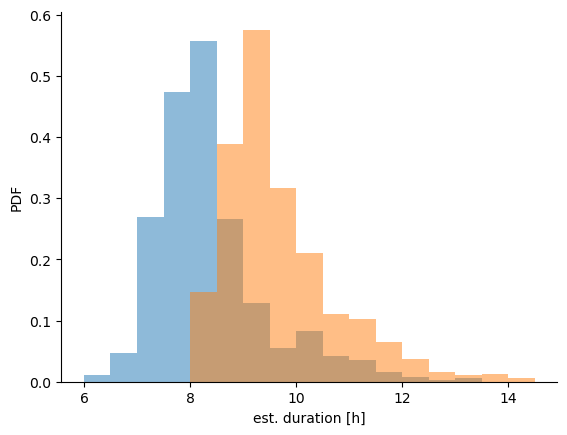

In [10]:
bins = np.arange(6, 15, 0.5)
plt.hist(durations_east, bins, alpha = 0.5, density = True)
plt.hist(durations_west, bins, alpha = 0.5, density = True)

plt.xlabel('est. duration [h]')
plt.ylabel('PDF')

sn.despine();

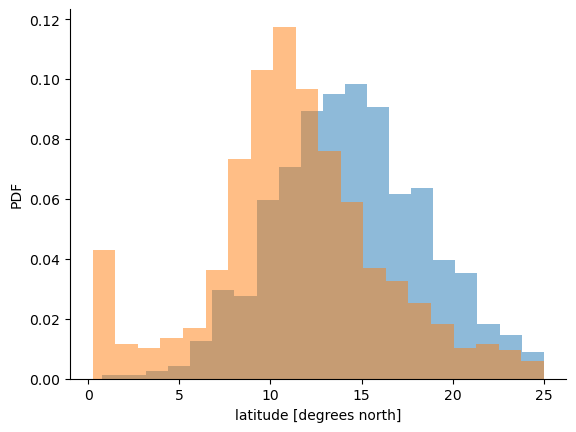

In [11]:
bins = 20 #np.arange(6, 15, 0.5)
plt.hist(c_norths_east, bins, alpha = 0.5, density = True)
plt.hist(c_norths_west, bins, alpha = 0.5, density = True)

plt.xlabel('latitude [degrees north]')
plt.ylabel('PDF')

sn.despine();

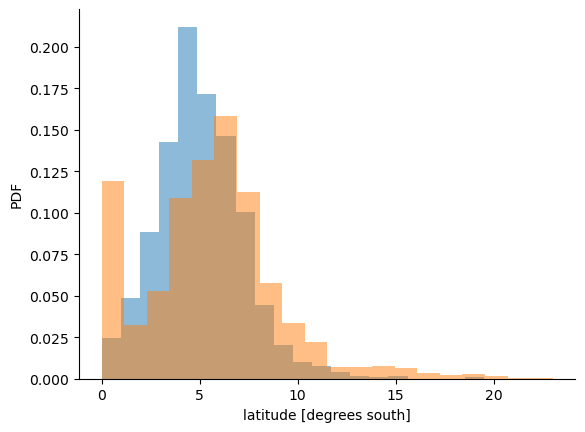

In [12]:
bins = 20 #np.arange(6, 15, 0.5)
plt.hist(c_souths_east, bins, alpha = 0.5, density = True)
plt.hist(c_souths_west, bins, alpha = 0.5, density = True)

plt.xlabel('latitude [degrees south]')
plt.ylabel('PDF')

sn.despine();